In [ ]:
# default_exp load_model

# Load Model

In [ ]:
#hide
from nbdev.showdoc import *
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export
import torch 
import yaml
from fastcore.script import *
from swfd.recursos.model import *
import csv
import numpy as np
import os
import matplotlib.pyplot as plt
from swfd.web_scraping import *

loadModel(pathrun): Funcion que pasándole la dirección de una run saca su modelo

In [ ]:
#export
def loadModel(pathrun):
    pathyaml=str(pathrun)+"config.yaml"
    pathpth=str(pathrun)+"best.pth"
    config=yaml.safe_load(open(str(pathyaml)))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NBeatsNet(device=device,stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  nb_blocks_per_stack=config["nb_blocks_per_stack"]["value"],
                  thetas_dims=config["thetas_dims"]["value"],
                  hidden_layer_units=config["hidden_layer_units"]["value"],
                  forecast_length=config["horizon"]["value"],backcast_length=config["lookback"]["value"])
    checkpoint = torch.load(pathpth,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model


In [ ]:
#hide
currentfolderpathtest=os.getcwd()
pathmodeltest=currentfolderpathtest+"/test/example_run_forecast7/"
modeltest=loadModel(pathmodeltest)
modeltest

NBeatsNet(
  (parameters): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 128x42]
      (1): Parameter containing: [torch.FloatTensor of size 128]
      (2): Parameter containing: [torch.FloatTensor of size 128x128]
      (3): Parameter containing: [torch.FloatTensor of size 128]
      (4): Parameter containing: [torch.FloatTensor of size 128x128]
      (5): Parameter containing: [torch.FloatTensor of size 128]
      (6): Parameter containing: [torch.FloatTensor of size 128x128]
      (7): Parameter containing: [torch.FloatTensor of size 128]
      (8): Parameter containing: [torch.FloatTensor of size 7x128]
      (9): Parameter containing: [torch.FloatTensor of size 7x128]
      (10): Parameter containing: [torch.FloatTensor of size 42x7]
      (11): Parameter containing: [torch.FloatTensor of size 42]
      (12): Parameter containing: [torch.FloatTensor of size 7x7]
      (13): Parameter containing: [torch.FloatTensor of size 7]
      (14): Parameter conta

getcsvdata(lookback):Funcion que devuelve el numero de valores de sfu empezando en el dia actual "lookback" veces.

In [ ]:
#export
def getcsvdata(lookback):
    pathfoldercsv=getInfo("csvdirectory") #Obtiene del txt el path del csv
    csvname="sfuData.csv" #Siempre se llamara así
    datalist=[]
    try:       
        with open(str(pathfoldercsv)+str(csvname)) as csv_file:
            forecastcount=0
            for row in reversed(list(csv.reader(csv_file, delimiter=','))):
                if(forecastcount<lookback):
                    datalist=np.append(datalist,float(row[1]))
                    forecastcount=forecastcount+1
                    
    finally:
        csv_file.close()
    return datalist


In [ ]:
#hide
getcsvdata(7)

array([72.9, 73.7, 73.4, 73.7, 75.5, 75.6, 76.3])

getnamerunfolders(horizon,runshorizonfolder): Funcion que devuelve lista con el directorio de todas las carpetas de un horizonte

In [ ]:
#export
def getnamerunfolders(horizon,runshorizonfolder): 
    runshorizonfolder=runshorizonfolder+"ensembleH"+str(horizon)
    pathfolderruns=[]
    contenido = os.listdir(str(runshorizonfolder))
    for i in contenido:
        pathrun=runshorizonfolder+"/"+str(i)+"/"
        pathfolderruns.append(pathrun)
    
    return pathfolderruns


In [ ]:
#hide
getnamerunfolders(7,"/home/miguel/Escritorio/tfg_swf/csv/pth/")

['/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_22/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_3/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_20/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_72/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_28/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_87/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_12/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_89/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_86/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_49/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_70/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_80/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_41/',
 '/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_71/',
 '/home/miguel/Escritorio/tfg_swf/c

singleprediction(path,normalize): Funcion que hace la prediccion de una run concreta(carpeta individual)

In [ ]:
#export
def singleprediction(filepath,normalize):
    net=loadModel(str(filepath))
    lookback=net.backcast_length
    data=getcsvdata(lookback)
    row = torch.Tensor([data/normalize])
    backcast,forecast = net(row)
    preds_tensor=(forecast.detach().numpy())*normalize
    return preds_tensor[0]


In [ ]:
#hide
currentfolderpathtest=os.getcwd()
runpathtest=currentfolderpathtest+"/test/example_run_forecast3/" #"/test/example_run_forecast7/"
#runpath=currentfolderpath+"/test/example_run_forecast7/"
predicttest=singleprediction(runpathtest,938.6)
predicttest

array([79.85754, 83.43284, 94.86105], dtype=float32)

ensembleprediction(path,normalize): Funcion que se recorre cada carpeta de un horizonte y hace la predicion para cada run, devolviendo una lista con todas las predicciones.

In [ ]:
#export
def ensembleprediction(horizon,normalize):
    prediction=[]
    folderpath=getInfo("pthdirectory")
    runspath=getnamerunfolders(horizon,folderpath)
    for run in runspath:
        prediction.append(singleprediction(run,normalize))
    return prediction

In [ ]:
#hide
predicttest=ensembleprediction(5,938.6)
#prediction=ensembleprediction(3,938.6)
print(predicttest)
print(len(predicttest))#len de 3 es el unico que tiene 180, el resto90

[array([74.981155, 92.93279 , 92.622154, 79.89616 , 86.963745],
      dtype=float32), array([84.54304 , 91.930885, 87.835915, 91.26686 , 88.970436],
      dtype=float32), array([86.38434, 93.41148, 95.53563, 85.63299, 91.77669], dtype=float32), array([84.73564 , 76.66728 , 89.02227 , 85.671616, 90.735634],
      dtype=float32), array([80.499985, 84.37188 , 77.60178 , 83.79948 , 76.84219 ],
      dtype=float32), array([86.80842 , 91.533325, 82.43016 , 84.47903 , 86.20782 ],
      dtype=float32), array([88.46016 , 95.98141 , 80.343925, 85.026245, 84.27839 ],
      dtype=float32), array([73.78886 , 96.20657 , 91.785286, 87.34165 , 80.62271 ],
      dtype=float32), array([86.00594 , 94.54687 , 88.13045 , 90.267975, 95.38281 ],
      dtype=float32), array([91.4103  , 82.90245 , 91.30496 , 95.156494, 98.4752  ],
      dtype=float32), array([82.62045, 85.30244, 82.89681, 88.06808, 91.41293], dtype=float32), array([79.20084 , 88.19611 , 91.729836, 86.99387 , 84.817085],
      dtype=float32), a

ensembleMeanVar(prediction): Funcion que hace la media y varianza de los valores predichos

In [ ]:
#export
def ensembleMeanVar(prediction):
    matrix = [] 
    invertiblematrix=[]
    meanlist=[]
    stdlist=[]
    for i in range (0,len(prediction[0])):#Horizon que sera la longitud de la prediccion invidual en una run
        matrix = []
        for j in range(0,len(prediction)):#num de runs que se han hecho, es el numero de prediciones hechas
            matrix.append(prediction[j][i])
        invertiblematrix.append(matrix)
        
    for element in invertiblematrix:
        nparray=np.array(element,float)
        meanlist.append(nparray.mean())
        stdlist.append(nparray.std())
    
    return np.array(meanlist),np.array(stdlist)

In [ ]:
#hide
#predicttest=ensembleprediction(5,938.6)
ensembleMeanVar(predicttest)

(array([86.25172484, 89.57166015, 88.31796358, 88.67318929, 88.88809085]),
 array([9.19489042, 8.02982189, 8.1236641 , 8.54230127, 7.08595832]))

predecir(forecast): Funcion general que invoca a las demas funciones para cargar y ver el modelo

In [ ]:
#export
def modelprediction(forecast,normal):#Parametro normal esta para hacer pruebas
    #normalize=getMaxValueSfu()
    normalize=normal#Funcion web_scraping getMaxValueSfu(), funciona, pero parra ahorrar tiempo en las pruebas
  
    prediction=ensembleprediction(forecast,normalize)
    
    mean,std=ensembleMeanVar(prediction)
    return prediction,mean,std 


In [ ]:
#hide
forecasttest=5
globalpredicttest,meantest,stdtest=modelprediction(forecasttest,938.6)
print("----Predict----\n",globalpredicttest,"\n\n----Mean----\n",meantest,"\n\n----Std----\n",stdtest)

----Predict----
 [array([74.981155, 92.93279 , 92.622154, 79.89616 , 86.963745],
      dtype=float32), array([84.54304 , 91.930885, 87.835915, 91.26686 , 88.970436],
      dtype=float32), array([86.38434, 93.41148, 95.53563, 85.63299, 91.77669], dtype=float32), array([84.73564 , 76.66728 , 89.02227 , 85.671616, 90.735634],
      dtype=float32), array([80.499985, 84.37188 , 77.60178 , 83.79948 , 76.84219 ],
      dtype=float32), array([86.80842 , 91.533325, 82.43016 , 84.47903 , 86.20782 ],
      dtype=float32), array([88.46016 , 95.98141 , 80.343925, 85.026245, 84.27839 ],
      dtype=float32), array([73.78886 , 96.20657 , 91.785286, 87.34165 , 80.62271 ],
      dtype=float32), array([86.00594 , 94.54687 , 88.13045 , 90.267975, 95.38281 ],
      dtype=float32), array([91.4103  , 82.90245 , 91.30496 , 95.156494, 98.4752  ],
      dtype=float32), array([82.62045, 85.30244, 82.89681, 88.06808, 91.41293], dtype=float32), array([79.20084 , 88.19611 , 91.729836, 86.99387 , 84.817085],
      

In [ ]:
#hide
#Funcion temporal para mostrar el modelo
def showmodel(horizon,normal):
    lookback=horizon*6  
    data=getcsvdata(lookback)
    predict,mean,std=modelprediction(horizon,normal)
    
    forecastlist=[]
    for i in range(0,horizon):
        forecastlist.append(lookback+i)
        i=i+1
    plt.plot(data[::-1],"r--",forecastlist,mean)
    plt.fill_between(forecastlist, mean-std, mean+std,alpha=0.5)
    plt.show()

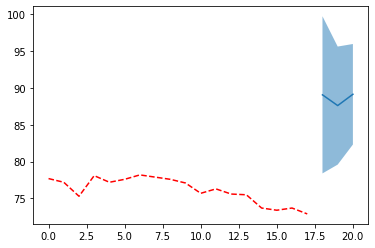

In [ ]:
#hide
#Funcion con horizon=3 y maximo valor desde 1949 de la essa
showmodel(3,938.6)

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


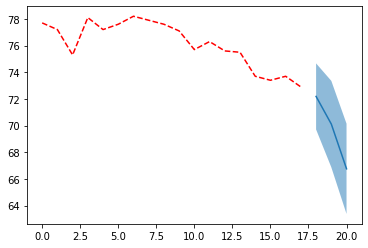

In [ ]:
#hide
#Funcion con horizon y valor aleatorio de normalize = 122
showmodel(3,122)

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


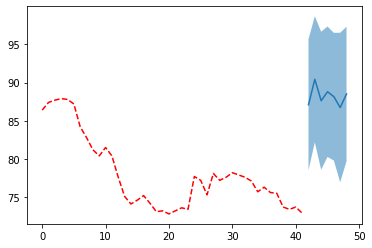

In [ ]:
#hide
#Funcion con horizon=7 y maximo valor desde 1949 de la essa
showmodel(7,938.6)

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


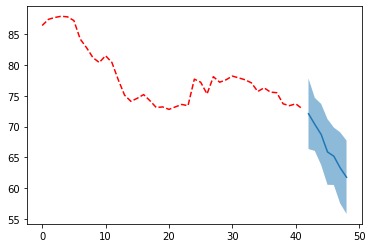

In [ ]:
#hide
#Funcion con horizon y valor aleatorio de normalize = 122
showmodel(7,122)

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


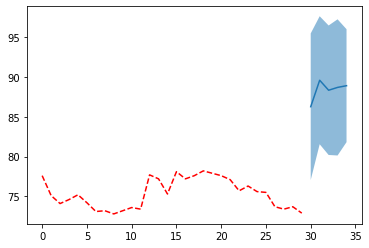

In [ ]:
#hide
showmodel(5,938.6)

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


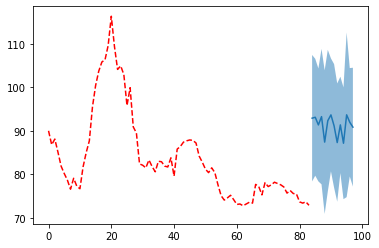

In [ ]:
#hide
showmodel(14,938.6)

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


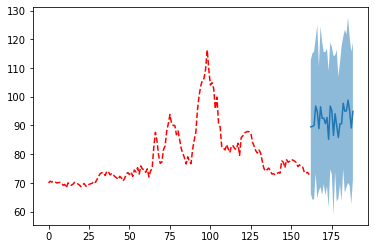

In [ ]:
#hide
showmodel(27,938.6)

In [ ]:
#hide
maxvaluesdf=getMaxValueSfu()
print(maxvaluesdf)

938.6
